In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import Delaunay
from form_factor import *

In [2]:
# ================================================================
# SECTION: Mesh Visualization and Analysis
# ================================================================

# ---------------------------
# Plot Tetrahedra with Center Offset
# ---------------------------
def plot_tetrahedra_center_offset(verts, tetrahedra, offset=0.2, noaxis=False):
    """
    Visualize tetrahedra with slight offset from their center to avoid overlap.

    Parameters:
    - verts: (N, 3) array of vertex coordinates
    - tetrahedra: (M, 4) array of tetrahedron vertex indices
    - offset: float
        Multiplier applied to center of each tetrahedron for visualization.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for tet in tetrahedra:
        tet_verts = verts[tet]
        center = tet_verts.mean(axis=0)
        shifted = tet_verts + offset * center

        faces = [
            [shifted[0], shifted[1], shifted[2]],
            [shifted[0], shifted[1], shifted[3]],
            [shifted[0], shifted[2], shifted[3]],
            [shifted[1], shifted[2], shifted[3]],
        ]
        poly = Poly3DCollection(faces, alpha=0.5, edgecolor='k')  # For reproducibility
        poly.set_facecolor(np.random.rand(3,))
        ax.add_collection3d(poly)

    all_shifted = np.vstack([verts[tet] + offset * verts[tet].mean(axis=0) for tet in tetrahedra])
    max_range = (all_shifted.max(axis=0) - all_shifted.min(axis=0)).max() / 2.0
    mid = all_shifted.mean(axis=0)

    for axis, m in zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], mid):
        axis(m - max_range, m + max_range)

    ax.set_box_aspect([1, 1, 1])
    
    if noaxis:
        ax.set_axis_off()
        
    plt.tight_layout()
    plt.show()

# ---------------------------
# Compute Volume of Tetrahedra
# ---------------------------
def compute_tetrahedra_volumes(verts, tetrahedra):
    """
    Compute volume of each tetrahedron.

    Parameters:
    - verts: (N, 3)
    - tetrahedra: (M, 4)

    Returns:
    - volumes: (M,) np.ndarray of positive volumes.
    """
    v0 = verts[tetrahedra[:, 0]]
    v1 = verts[tetrahedra[:, 1]]
    v2 = verts[tetrahedra[:, 2]]
    v3 = verts[tetrahedra[:, 3]]

    cross = np.cross(v1 - v0, v2 - v0)
    dot = np.einsum('ij,ij->i', cross, v3 - v0)
    volumes = np.abs(dot) / 6.0
    return volumes

# ---------------------------
# Fix Tetrahedron Orientations
# ---------------------------
def fix_tetrahedron_orientations(verts, tetrahedra):
    """
    Ensure all tetrahedra are right-handed (positive volume).

    Parameters:
    - verts: (N, 3)
    - tetrahedra: (M, 4)

    Returns:
    - corrected_tetrahedra: (M, 4)
    """
    corrected = tetrahedra.copy()

    for i, tet in enumerate(tetrahedra):
        v0, v1, v2, v3 = verts[tet]
        signed_vol = np.dot(np.cross(v1 - v0, v2 - v0), v3 - v0)
        if signed_vol < 0:
            corrected[i] = [tet[0], tet[2], tet[1], tet[3]]  # Swap to fix parity

    return corrected

In [3]:
import numpy as np
import itertools
import math
from scipy.spatial import ConvexHull

def wythoff_seed(u, v):
    """
    Wythoff seed in the fundamental spherical triangle with vertices
    (100), (110), (111) directions.

    Parameters
    ----------
    u, v : float
        Barycentric parameters with constraints:
            u >= 0, v >= 0, u + v <= 1
        Interior (u > 0, v > 0, u+v < 1) gives a generic 4.6.8 vertex figure
        (truncated-cuboctahedral combinatorics).

    Returns
    -------
    seed : (3,) ndarray
        Unit vector on S^2.
    """
    if u < -1e-12 or v < -1e-12 or u + v > 1 + 1e-12:
        raise ValueError("u, v must satisfy u >= 0, v >= 0, u + v <= 1")

    # Directions for (100), (110), (111) normalized
    a = np.array([1.0, 0.0, 0.0])
    b = np.array([1.0, 1.0, 0.0]) / np.sqrt(2.0)
    c = np.array([1.0, 1.0, 1.0]) / np.sqrt(3.0)

    # Affine combination then normalize back to the sphere
    alpha = 1.0 - u - v
    beta = u
    gamma = v

    x = alpha * a + beta * b + gamma * c
    x /= np.linalg.norm(x)
    return x


def octahedral_group():
    """
    Full octahedral symmetry group O_h as 48 orthogonal 3x3 matrices.

    Generated as all signed permutation matrices.
    """
    mats = []
    for perm in itertools.permutations(range(3)):
        P = np.eye(3)[list(perm)]
        for signs in itertools.product([-1, 1], repeat=3):
            S = np.diag(signs)
            M = S @ P
            if not any(np.allclose(M, N, atol=1e-12) for N in mats):
                mats.append(M)
    return mats


def orbit_vertices(seed, group, tol=1e-8):
    """
    Generate unique vertices from the orbit of `seed` under `group`.
    """
    verts = []
    for M in group:
        p = M @ seed
        for v in verts:
            if np.linalg.norm(p - v) < tol:
                break
        else:
            verts.append(p)
    return np.array(verts)


def compute_faces(vertices, tol=1e-6):
    """
    Compute polygonal faces from the convex hull by merging coplanar triangles.

    Returns
    -------
    faces : list of lists of int
        Each entry is a face as a cyclic list of vertex indices.
    """
    hull = ConvexHull(vertices)
    faces_by_plane = {}

    # Group triangular facets by supporting plane
    for simplex, eq in zip(hull.simplices, hull.equations):
        normal = eq[:3]
        d = eq[3]

        # Normalize (n, d) so that plane id is stable
        norm_len = np.linalg.norm(normal)
        normal = normal / norm_len
        d = d / norm_len

        # Fix sign in a canonical way (first non-small component > 0)
        for k in range(3):
            if abs(normal[k]) > tol:
                if normal[k] < 0:
                    normal = -normal
                    d = -d
                break

        key = tuple(np.round(np.concatenate([normal, [d]]), 6))

        if key not in faces_by_plane:
            faces_by_plane[key] = set()
        faces_by_plane[key].update(simplex)

    # For each plane, order vertices around the face
    faces = []
    for key, idxs in faces_by_plane.items():
        idxs = list(idxs)
        pts = vertices[idxs]
        normal = np.array(key[:3])

        # Face centroid
        c = pts.mean(axis=0)

        # Local 2D basis in the plane
        ref = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(ref, normal)) > 0.9:
            ref = np.array([0.0, 1.0, 0.0])

        u_axis = np.cross(normal, ref)
        u_axis /= np.linalg.norm(u_axis)
        v_axis = np.cross(normal, u_axis)

        # Project vertices to (u,v)-plane and sort by angle
        angles = []
        for i, p in enumerate(pts):
            vec = p - c
            x = np.dot(vec, u_axis)
            y = np.dot(vec, v_axis)
            angle = math.atan2(y, x)
            angles.append((angle, idxs[i]))

        angles.sort()
        face = [idx for angle, idx in angles]
        faces.append(face)

    return faces


def general_truncated_cuboctahedron(u, v, tol=1e-6):
    """
    Build a general truncated-cuboctahedron-type polyhedron from (u, v).

    Parameters
    ----------
    u, v : float
        Wythoff parameters in the fundamental triangle between
        (100), (110), (111). For a generic truncated-cuboctahedron
        combinatorics, use 0 < u, 0 < v, u + v < 1.
    tol : float
        Tolerance for merging vertices and planes.

    Returns
    -------
    vertices : (N, 3) ndarray
        Vertex coordinates (here N = 48 for generic interior (u, v)).
    faces : list of lists of int
        Proper face list (12 quads, 8 hexagons, 6 octagons), each face
        as a cyclic list of vertex indices.
    """
    seed = wythoff_seed(u, v)
    group = octahedral_group()
    vertices = orbit_vertices(seed, group, tol=tol)
    faces = compute_faces(vertices, tol=tol)
    return vertices, faces


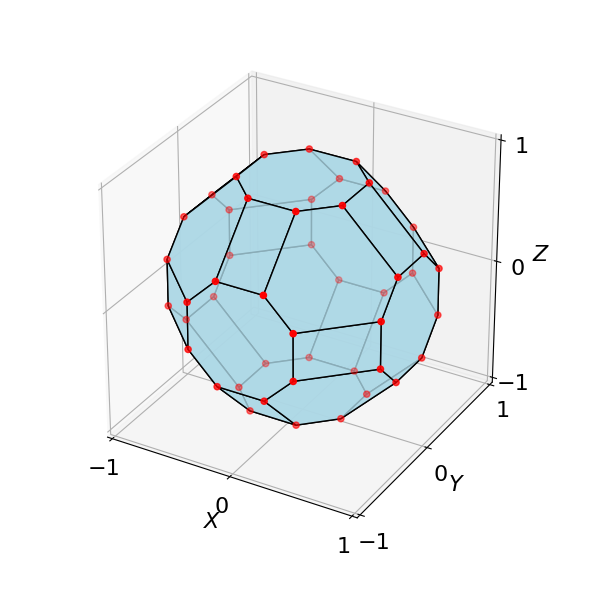

In [4]:
u, v = 0.3, 0.3
verts, faces = general_truncated_cuboctahedron(u, v)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

poly3d = [[verts[idx] for idx in face] for face in faces]
ax.add_collection3d(Poly3DCollection(poly3d, facecolors='lightblue', linewidths=1, edgecolors='k', alpha=0.8))

ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=20)

# Set equal aspect
max_range = (verts.max(axis=0) - verts.min(axis=0)).max() / 2.0
mid = verts.mean(axis=0)
for axis, m in zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], mid):
    axis(m - max_range, m + max_range)

ax.tick_params(which='major', labelsize=16)
ax.set_xlabel('$X$', fontsize=16)
ax.set_ylabel('$Y$', fontsize=16)
ax.set_zlabel('$Z$', fontsize=16)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])
ax.set_box_aspect([1,1,1], zoom=0.85)

plt.tight_layout()
plt.show()

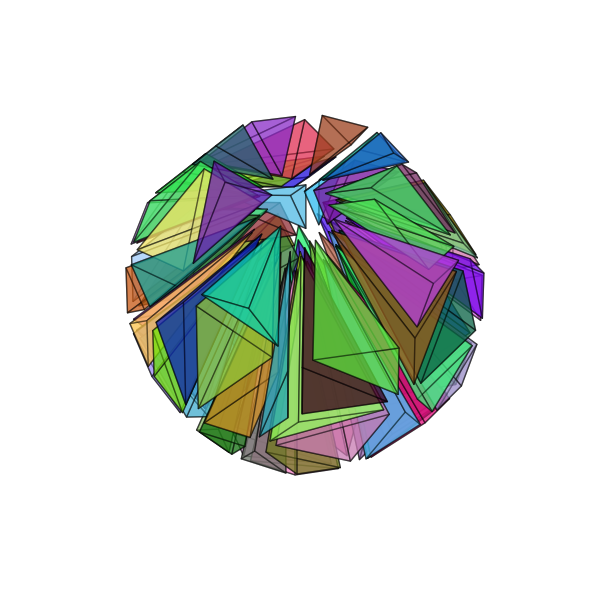

In [5]:
# Dissect the bifrustum into tetrahedra
delaunay = Delaunay(verts)
tetrahedra = delaunay.simplices

# Compute volumes of all tetrahedra
tetra_volumes = compute_tetrahedra_volumes(verts, tetrahedra)

# Filter out near-zero volume tetrahedra (threshold = 1e-6)
volume_threshold = 1e-6
valid_indices = np.where(tetra_volumes > volume_threshold)[0]

# Filter tetrahedra and volumes
filtered_tetrahedra = tetrahedra[valid_indices]
filtered_volumes = tetra_volumes[valid_indices]

total_volume = np.sum(filtered_volumes)

# Apply orientation correction to the tetrahedral mesh
tetrahedra_fixed = fix_tetrahedron_orientations(verts, filtered_tetrahedra)

# Visualize the result
plot_tetrahedra_center_offset(verts, tetrahedra_fixed, offset=0.5, noaxis=True)

In [6]:
# Grid resolution
n_grid = 100
q_scale = 20.0
qx = np.linspace(-1, 1, n_grid) * q_scale
qy = np.linspace(-1, 1, n_grid) * q_scale
qz = np.linspace(-1, 1, n_grid) * q_scale

# --- OLD (coordinate planes) ---
# q_grid_xy = np.meshgrid(qx, qy, [0], indexing='ij')
# q_grid_xz = np.meshgrid(qx, [0], qz, indexing='ij')
# q_grid_yz = np.meshgrid([0], qy, qz, indexing='ij')

# ------------------------------------------------------------------
# NEW: parameter grid for planes ⟂ (100), (110), (111)
# ------------------------------------------------------------------
t = np.linspace(-1, 1, n_grid) * q_scale
zeros = [0.0]

# Shared 2D parameter grid (u,v); we keep a dummy 3rd axis to stay
# consistent with your meshgrid(..., [0]) format.
u_grid, v_grid, _ = np.meshgrid(t, t, zeros, indexing='ij')

# ==============================================================
# Plane normal to (100): basis e_u = (0,1,0), e_v = (0,0,1)
# Q = u * (0,1,0) + v * (0,0,1)
# ==============================================================
Qx_100 = np.zeros_like(u_grid)
Qy_100 = u_grid
Qz_100 = v_grid
q_grid_100 = [Qx_100, Qy_100, Qz_100]

# ==============================================================
# Plane normal to (110):
#  n110   = (1, 1, 0) / √2
#  e_u    = (1,-1,0) / √2  (in-plane)
#  e_v    = (0, 0, 1)
# Q = u * e_u + v * e_v
# ==============================================================
inv_sqrt2 = 1.0 / np.sqrt(2.0)

Qx_110 =  u_grid * inv_sqrt2
Qy_110 = -u_grid * inv_sqrt2
Qz_110 =  v_grid
q_grid_110 = [Qx_110, Qy_110, Qz_110]

# ==============================================================
# Plane normal to (111):
#  n111   = (1, 1, 1) / √3
#  e_u    = (1,-1,0)/√2
#  e_v    = (1, 1,-2)/√6
# Q = u * e_u + v * e_v
# ==============================================================
inv_sqrt6 = 1.0 / np.sqrt(6.0)

Qx_111 =  u_grid * inv_sqrt2 + v_grid * inv_sqrt6
Qy_111 = -u_grid * inv_sqrt2 + v_grid * inv_sqrt6
Qz_111 = -2.0 * v_grid * inv_sqrt6
q_grid_111 = [Qx_111, Qy_111, Qz_111]

# ------------------------------------------------------------------
# Evaluate scattering intensity on the three planes
# ------------------------------------------------------------------
I_q_flat_100 = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_100)
I_q_100 = I_q_flat_100.reshape((n_grid, n_grid)) / total_volume**2

I_q_flat_110 = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_110)
I_q_110 = I_q_flat_110.reshape((n_grid, n_grid)) / total_volume**2

I_q_flat_111 = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_111)
I_q_111 = I_q_flat_111.reshape((n_grid, n_grid)) / total_volume**2


In [7]:
# Compute full 3D scattering function
q_range = 1.0*q_scale
n_q = 100
qx_3d = np.linspace(-q_range, q_range, n_q)
qy_3d = np.linspace(-q_range, q_range, n_q)
qz_3d = np.linspace(-q_range, q_range, n_q)

q_grid_3d = np.meshgrid(qx_3d, qy_3d, qz_3d, indexing='ij')
I_q_flat = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_3d)
I_q_3d = I_q_flat.reshape((n_q, n_q, n_q)) / total_volume**2

# Compute |Q| for radial averaging
Q_mag = np.sqrt(q_grid_3d[0]**2 + q_grid_3d[1]**2 + q_grid_3d[2]**2).flatten()
I_vals = I_q_3d.flatten()

# Bin into radial shells
Q_bins = np.linspace(0, q_range * np.sqrt(3), 100)
Q_centers = 0.5 * (Q_bins[:-1] + Q_bins[1:])
I_avg = np.zeros_like(Q_centers)
counts = np.zeros_like(Q_centers)

for i in range(len(Q_centers)):
    mask = (Q_mag >= Q_bins[i]) & (Q_mag < Q_bins[i + 1])
    if np.any(mask):
        I_avg[i] = I_vals[mask].mean()
        counts[i] = np.sum(mask)

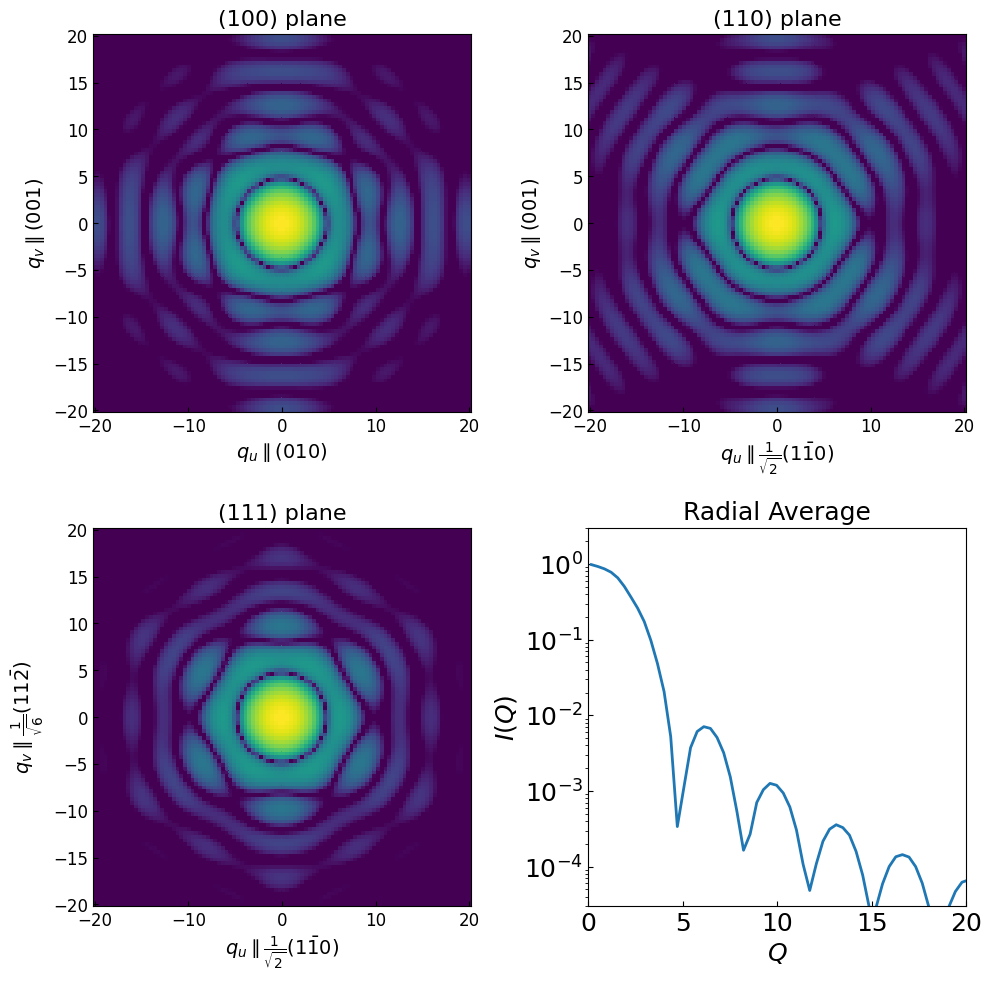

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Use 2D slices of the parameter grid for plotting
u2d = u_grid[:, :, 0]
v2d = v_grid[:, :, 0]

# ----------------------------------------------------------
# (100) plane
# ----------------------------------------------------------
pcm_100 = axes[0, 0].pcolor(
    u2d, v2d, np.log(I_q_100),
    cmap='viridis', vmax=0, vmin=-10
)
axes[0, 0].set_title('(100) plane', fontsize=16)
axes[0, 0].set_xlabel(r'$q_u \parallel (010)$', fontsize=14)
axes[0, 0].set_ylabel(r'$q_v \parallel (001)$', fontsize=14)
axes[0, 0].set_aspect('equal')
axes[0, 0].tick_params(direction='in', labelsize=12)

# ----------------------------------------------------------
# (110) plane
# ----------------------------------------------------------
pcm_110 = axes[0, 1].pcolor(
    u2d, v2d, np.log(I_q_110),
    cmap='viridis', vmax=0, vmin=-10
)
axes[0, 1].set_title('(110) plane', fontsize=16)
axes[0, 1].set_xlabel(r'$q_u \parallel \frac{1}{\sqrt{2}}(1\bar{1}0)$', fontsize=14)
axes[0, 1].set_ylabel(r'$q_v \parallel (001)$', fontsize=14)
axes[0, 1].set_aspect('equal')
axes[0, 1].tick_params(direction='in', labelsize=12)

# ----------------------------------------------------------
# (111) plane
# ----------------------------------------------------------
pcm_111 = axes[1, 0].pcolor(
    u2d, v2d, np.log(I_q_111),
    cmap='viridis', vmax=0, vmin=-10
)
axes[1, 0].set_title('(111) plane', fontsize=16)
axes[1, 0].set_xlabel(r'$q_u \parallel \frac{1}{\sqrt{2}}(1\bar{1}0)$', fontsize=14)
axes[1, 0].set_ylabel(r'$q_v \parallel \frac{1}{\sqrt{6}}(11\bar{2})$', fontsize=14)
axes[1, 0].set_aspect('equal')
axes[1, 0].tick_params(direction='in', labelsize=12)

# ----------------------------------------------------------
# Radial average
# ----------------------------------------------------------
axes[1, 1].plot(Q_centers, I_avg, lw=2)
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Radial Average', fontsize=18)
axes[1, 1].set_xlabel(r'$Q$', fontsize=18)
axes[1, 1].set_ylabel(r'$I(Q)$', fontsize=18)
axes[1, 1].set_xlim(0, np.max(qx_3d))
axes[1, 1].set_ylim(3e-5, 3e0)
axes[1, 1].set_aspect(np.max(qx_3d) / 5)
axes[1, 1].tick_params(direction='in', labelsize=18)

plt.tight_layout()
plt.show()
